In [1]:
# Hyperparameters
debug = False
MIN = 1 # n-gram
MAX = 1 # n-gram
MAX_DF = 0.6
HASH_POWER = 10 # hash to 2**HASH_POWER features

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import re
import nltk
import os

from tqdm import tqdm
from bs4 import BeautifulSoup
from summa import keywords
from summa.summarizer import summarize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [3]:
if not os.path.exists("output/") : os.mkdir("output/")

## 一. 資料前處理
首先先引入dataset

### 1.1 清掉所有的html tag

In [4]:
def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

### 1.2 定義tokenize+波特詞幹還原演算法+刪除停用字

In [5]:
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

print(tokenizer_stem_nostop('runners like running and thus they run')) # Test if it works

['runner', 'like', 'run', 'thu', 'run']


[nltk_data] Downloading package stopwords to /home/benny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.3 html語法分析

In [6]:
def fetch_datetime(text=[]):
    day = []
    for tx in text:
        soup = BeautifulSoup(tx, "lxml")
        if soup.time.has_attr('datetime'):
            date = soup.time.attrs['datetime']
            day.append(' '+ date[0:3])
        else:
            day.append(' fuckday')
    return day

def fetch_channel(text=[]):
    channels = []
    for tx in text:
        soup = BeautifulSoup(tx, "lxml")
        channel = soup.article['data-channel']
        channels.append(channel)
    return channels

def fetch_img_count(text=[]):
    count = []
    for tx in text:
        soup = BeautifulSoup(tx, "lxml")
        c = 0
        find_all_images = soup.find_all('img')
        for i in find_all_images:
            c = c+1
        count.append(c)
    return count

def fetch_topics(text=[]):
    topics = []
    for tx in text:
        soup = BeautifulSoup(tx, "lxml")
        footer = soup.footer
        ta = footer.find_all('a')
        topic = []
        for t in ta:
            topic.append(t.get_text())
        ff = ' '.join(topic)
        topics.append(ff)
    return topics

def fetch_authors(text=[]):
    authors = []
    for tx in text:
        soup = BeautifulSoup(tx, "lxml")
        footer = soup.span
        if footer != None:
            ta = footer.findAll('a')
            author = []
            for t in ta:
                author.append(t.get_text())
            if len(author) == 0:
                ff = 'NaN'
            else:
                ff = ''.join(author)
        else:
            ff = 'NaN'
        authors.append(ff)
    return authors

def fetch_titles(text=[]):
    titles = []
    for tx in text:
        soup = BeautifulSoup(tx, "lxml")
        footer = soup.h1
        if footer != None:
            ff = footer.get_text()
        else:
            ff = 'NaN'
        titles.append(ff) 
    return titles

def fetch_social_media_count(text=[]):
    count = []
    for tx in text:
        soup = BeautifulSoup(tx, "lxml")
        c = 0
        for frame in soup("iframe"):
#             print(frame.get('src').split("."))
            if frame.get('src').find("youtube") != None:
                c = c+1
            elif frame.get('src').find("instagram") != None:
                c = c+1
            elif frame.get('src').find("vine") != None:
                c= c+1
            # apply new media here
        count.append(c)
    return count

### 1.4 分析文章基本性質
例如作者,圖片數量等等

In [7]:
df = pd.read_csv('./input/train.csv')
if debug:
    df = df.iloc[:100] # debug
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


In [8]:
# fatch deature, 這裡可能需要15分鐘左右
topic_batch = fetch_topics(df[:]['Page content'])
channel_batch = fetch_channel(df[:]['Page content'])
weekday_batch = fetch_datetime(df[:]['Page content'])
author_batch = fetch_authors(df[:]['Page content'])
img_batch = fetch_img_count(df[:]['Page content'])
title_batch = fetch_titles(df[:]['Page content'])
media_batch = fetch_social_media_count(df[:]['Page content'])

In [9]:
# re-consturct training data
df_feature = pd.DataFrame({'topic':topic_batch,
                           'channel':channel_batch,
                           'weekday':weekday_batch,
                           'author':author_batch,
                           'img count':img_batch,
                           'title':title_batch,
                           'media count': media_batch})

In [10]:
display(df_feature.head(5))

,topic,channel,weekday,author,img count,title,media count
0,Asteroid Asteroids challenge Earth Space U.S. ...,world,Wed,NaN,1,NASA's Grand Challenge: Stop Asteroids From De...,0
1,Apps and Software Google open source opn pledg...,tech,Thu,Christina Warren,2,Google's New Open Source Patent Pledge: We Won...,0
2,Entertainment NFL NFL Draft Sports Television,entertainment,Wed,Sam Laird,2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,25
3,Sports Video Videos Watercooler,watercooler,Fri,Sam Laird,1,Cameraperson Fails Deliver Slapstick Laughs,21
4,Entertainment instagram instagram video NFL Sp...,entertainment,Thu,Connor Finnegan,52,NFL Star Helps Young Fan Prove Friendship With...,1


In [11]:
df = df.join(df_feature, lsuffix='_caller', rsuffix='_other')

In [13]:
tqdm.pandas()
df['Page content'] = df['Page content'].progress_apply(preprocessor) # 此步驟約要花五分鐘

100%|███████████████████████████████████████████████████████████████████████| 27643/27643 [01:21<00:00, 338.83it/s]


In [14]:
df.head(5)

,Id,Popularity,Page content,topic,channel,weekday,author,img count,title,media count
0,0,-1,clara moskowitz for space com 2013 06 19 15 0...,Asteroid Asteroids challenge Earth Space U.S. ...,world,Wed,NaN,1,NASA's Grand Challenge: Stop Asteroids From De...,0
1,1,1,by christina warren2013 03 28 17 40 55 utcgoog...,Apps and Software Google open source opn pledg...,tech,Thu,Christina Warren,2,Google's New Open Source Patent Pledge: We Won...,0
2,2,1,by sam laird2014 05 07 19 15 20 utcballin 2014...,Entertainment NFL NFL Draft Sports Television,entertainment,Wed,Sam Laird,2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,25
3,3,-1,by sam laird2013 10 11 02 26 50 utccameraperso...,Sports Video Videos Watercooler,watercooler,Fri,Sam Laird,1,Cameraperson Fails Deliver Slapstick Laughs,21
4,4,-1,by connor finnegan2014 04 17 03 31 43 utcnfl s...,Entertainment instagram instagram video NFL Sp...,entertainment,Thu,Connor Finnegan,52,NFL Star Helps Young Fan Prove Friendship With...,1


In [15]:
del df_feature

### 1.5 產生關鍵字

In [19]:
tqdm.pandas()
df['keywords'] = df['Page content'].progress_apply(tokenizer_stem_nostop)

100%|███████████████████████████████████████████████████████████████████████| 27643/27643 [01:45<00:00, 261.81it/s]


In [22]:
df['keywords'] = df['keywords'].progress_apply(lambda x: ' '.join(x))

100%|████████████████████████████████████████████████████████████████████| 27643/27643 [00:00<00:00, 224492.84it/s]


In [24]:
tqdm.pandas()
df['keywords'] = df['keywords'].progress_apply(lambda x: keywords.keywords(x).replace('\n', ' '))

100%|████████████████████████████████████████████████████████████████████████| 27643/27643 [20:57<00:00, 21.99it/s]


In [25]:
df.head(5)

,Id,Popularity,Page content,topic,channel,weekday,author,img count,title,media count,keywords
0,0,-1,clara moskowitz for space com 2013 06 19 15 0...,Asteroid Asteroids challenge Earth Space U.S. ...,world,Wed,NaN,1,NASA's Grand Challenge: Stop Asteroids From De...,0,nasa space mission said challeng stop asteroid...
1,1,1,by christina warren2013 03 28 17 40 55 utcgoog...,Apps and Software Google open source opn pledg...,tech,Thu,Christina Warren,2,Google's New Open Source Patent Pledge: We Won...,0,googl softwar new open sourc patent pledg sue ...
2,2,1,by sam laird2014 05 07 19 15 20 utcballin 2014...,Entertainment NFL NFL Draft Sports Television,entertainment,Wed,Sam Laird,2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,25,bonu youtub funniest sport fail win nfl draft ...
3,3,-1,by sam laird2013 10 11 02 26 50 utccameraperso...,Sports Video Videos Watercooler,watercooler,Fri,Sam Laird,1,Cameraperson Fails Deliver Slapstick Laughs,21,fail video sport second youtub need littl laug...
4,4,-1,by connor finnegan2014 04 17 03 31 43 utcnfl s...,Entertainment instagram instagram video NFL Sp...,entertainment,Thu,Connor Finnegan,52,NFL Star Helps Young Fan Prove Friendship With...,1,stadium imag getti game watt world championshi...


In [26]:
df.to_csv('./input/input_feature.csv')

可以丟下去做onehot的有channel，weekday，img count，media count,因為topic和title已經包含在文章內了,而我們取關鍵字是連著他們一起取的.

## 二. 特徵選擇

In [4]:
df = pd.read_csv('./input/input_feature.csv')

### 2.1 找出頻率最高的詞

In [16]:
count = CountVectorizer(ngram_range=(1, 1), # (MIN, MAX)
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)
count.fit(["YEAH TIGER", "FIBER WIPER"]) # need to fit something first

C:\Users\acer\anaconda3\envs\tf\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(preprocessor=<function preprocessor at 0x00000149A614A8B0>,
                tokenizer=<function tokenizer_stem_nostop at 0x00000149A1AE6940>)

In [17]:
doc = df['Page content']
doc_bag = count.fit_transform(doc).toarray()

print("[most frequent vocabularies]")
bag_cnts = np.sum(doc_bag, axis=0)
top = 10
# [::-1] reverses a list since sort is in ascending order
for tok, v in zip(count.inverse_transform(np.ones(bag_cnts.shape[0]).reshape(1, -1))[0][bag_cnts.argsort()[::-1][:top]], 
                  np.sort(bag_cnts)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[most frequent vocabularies]
imag: 116996
also: 51161
new: 44159
one: 42492
video: 41798
see: 38955
like: 36858
time: 35997
use: 33510
app: 32685


### 2.2 基於整個文本的TF-IDF

利用前面所定義的前處理方法產生tf-idf向量

In [7]:
doc = df['Page content']
tfidf = TfidfVectorizer(ngram_range=(MIN, MAX), 
                        preprocessor=preprocessor, 
                        tokenizer=tokenizer_stem_nostop, 
                        max_df=MAX_DF, 
                        min_df=0.0001)
tfidf.fit(doc)
doc_tfidf = tfidf.transform(doc).toarray()

/home/benny/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [8]:
print(doc_tfidf.shape)

(27643, 43634)


In [14]:
np.savetxt("tfidf.csv", doc_tfidf, delimiter=",")

接著調查idf分數以及tf-idf值最大的10個單字

In [9]:
top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    print('%s: %.2f' %(tfidf.get_feature_names()[sorted_idx[i]], idf[sorted_idx[i]]))


tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones(tfidf_sum.shape[0]).reshape(1, -1))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[vocabularies with smallest idf scores]
new: 1.56
like: 1.60
time: 1.61
make: 1.72
year: 1.73
world: 1.75
use: 1.77
get: 1.79
first: 1.85
take: 1.90

[vocabularies with highest tf-idf scores]
video: 733.5061786531768
app: 602.2534993946733
new: 500.9036433140395
googl: 455.2371136820567
game: 442.6232487233518
twitter: 414.0212743230195
facebook: 410.4951735218714
compani: 403.128044066731
appl: 401.1395615393847
time: 400.9980301873785


In [ ]:
del doc_tfidf

### 2.3 基於關鍵字的tf-idf

In [27]:
doc = df['keywords']
tfidf = TfidfVectorizer(ngram_range=(1, 1), 
                        preprocessor=preprocessor, 
                        tokenizer=tokenizer_stem_nostop)
tfidf.fit(doc)
doc_tfidf = tfidf.transform(doc).toarray()

/home/benny/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [28]:
print(doc_tfidf.shape)

(27643, 39431)


In [29]:
top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    print('%s: %.2f' %(tfidf.get_feature_names()[sorted_idx[i]], idf[sorted_idx[i]]))


tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones(tfidf_sum.shape[0]).reshape(1, -1))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[vocabularies with smallest idf scores]
imag: 1.94
new: 2.23
like: 2.35
time: 2.47
use: 2.55
video: 2.59
make: 2.61
year: 2.66
said: 2.70
compani: 2.79

[vocabularies with highest tf-idf scores]
imag: 639.4314030667334
new: 543.6068855046963
video: 487.298715875056
like: 460.2245497275674
time: 431.4077628796134
use: 427.29808775659825
compani: 402.0364173369534
make: 393.66282963562537
year: 391.85262234595297
said: 379.9360365379158


In [ ]:
del doc_tfidf

### 2.4 Feature Hashing
hash words to 1024 or 2048 buckets

In [5]:
doc = df['keywords']
#doc = df['Page content']
hashvec = HashingVectorizer(n_features=2**HASH_POWER)

no .fit needed for HashingVectorizer, since it's defined by the hash function. transform sentences to vectors of dimension 1024

In [6]:
doc_hash = hashvec.transform(doc).toarray()
print(doc_hash.shape)

(27643, 1024)


### 2.5 One hot Encoding

In [7]:
# channel
channel_ohe = OneHotEncoder(handle_unknown='ignore')
channel_str = channel_ohe.fit_transform(df['channel'].values.reshape(-1,1)).toarray()
print(channel_str.shape)

# weekday
weekday_ohe = OneHotEncoder(handle_unknown='ignore')
weekday_str = weekday_ohe.fit_transform(df['weekday'].values.reshape(-1,1)).toarray()
print(weekday_str.shape)

# ohe author
author_ohe = OneHotEncoder(handle_unknown='ignore')
author_str = author_ohe.fit_transform(df['author'].values.reshape(-1,1)).toarray()
print(author_str.shape)

(27643, 33)
(27643, 7)
(27643, 428)


把所有特徵給組合起來

In [8]:
img_count = df['img count'].values.reshape(-1,1)
media_count = df['media count'].values.reshape(-1,1)
df_y_train = df['Popularity'].to_numpy()
del df

In [9]:
def flatten(t):
    return [item for sublist in t for item in sublist]

df_X_train = []
for i in tqdm(range(len(channel_str))):
    temp = []
    temp.append(img_count[i])
    temp.append(media_count[i])
    temp.append(channel_str[i])
    temp.append(weekday_str[i])
    temp.append(author_str[i])
    temp.append(doc_hash[i])
    df_X_train.append(flatten(temp))
    del temp

100%|█████████████████████████████████████████████████████████████████████| 27643/27643 [00:01<00:00, 13858.71it/s]


In [10]:
del doc_hash, img_count, media_count, channel_str, weekday_str, author_str

In [11]:
print(len(df_X_train),len(df_X_train[0]))

27643 1494


存成csv檔案就不用再重跑之前的code了

In [12]:
pd.DataFrame(df_X_train).to_csv("./input/X_train.csv", index=False, header=False)
pd.DataFrame(df_y_train).to_csv("./input/y_train.csv", index=False, header=False)

生成training set和testing set

## 三. 模型訓練
直接從這裡開始跑

In [15]:
df_X_train = pd.read_csv('./input/X_train.csv', header=None).values
df_y_train = pd.read_csv('./input/y_train.csv', header=None).values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_X_train, df_y_train, test_size=0.2)

In [17]:
del df_X_train
del df_y_train

### 3.1 PCA降維

In [15]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [17]:
cov_mat = np.cov(X_train_std.T) # 計算特徵值
eigen_vals, _ = np.linalg.eig(cov_mat)

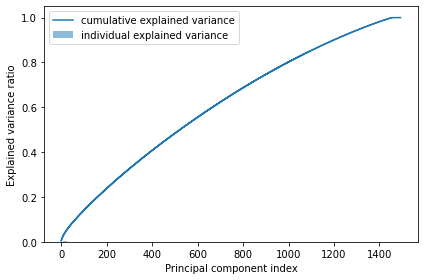

In [27]:
# 把explained variance(lambda i / lambda和)由大排到小
tot = sum(eigen_vals)
var_exp = np.array([(i / tot) for i in sorted(eigen_vals, reverse=True)])
cum_var_exp = np.cumsum(var_exp) # 計算解釋變異數

# 繪圖
plt.bar(range(len(eigen_vals)), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(len(eigen_vals)), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

In [35]:
del X_train_std, X_train_pca, X_test_pca, X_test_std

### 3.2 Logistic Regression

In [67]:
pipe_lr2 = make_pipeline(StandardScaler(),
                         PCA(n_components=1200),
                         LogisticRegression(penalty='l2',
                                            C=1e-5, 
                                            random_state=1, 
                                            solver='lbfgs', 
                                            multi_class='ovr', 
                                            verbose=0))

In [68]:
pipe_lr2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=1200)),
                ('logisticregression',
                 LogisticRegression(C=1e-05, multi_class='ovr',
                                    random_state=1))])

In [69]:
y_pred = pipe_lr2.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr2.score(X_test, y_test))
scores = cross_val_score(estimator=pipe_lr2, 
                         X=X_test, 
                         y=y_test, 
                         cv=10, 
                         verbose = 0,
                         scoring='roc_auc')
print('AUC score: %.3f (+/-%.3f)' % (scores.mean(), scores.std()))

Test Accuracy: 0.545
AUC score: 0.537 (+/-0.024)


## 四. 參數調整
使用Grid search

In [18]:
pipe_lr = make_pipeline(StandardScaler(),
                        #PCA(n_components=1000),
                        LogisticRegression(random_state=0))

In [22]:
import warnings
warnings.filterwarnings("ignore")

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
param_grid = [{'logisticregression__C': param_range, 
               'logisticregression__penalty': ['l2'],
               'logisticregression__class_weight': ['balanced', None],
               'logisticregression__solver': ['saga', 'lbfgs']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='roc_auc', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train.ravel())

# 輸出結果
print(gs.best_score_) 
print(gs.best_params_) # 最佳參數組合

0.5512980831004091
{'logisticregression__C': 0.0001, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}


In [23]:
clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train, y_train) # 用這個參數train出model
print('Test accuracy: %.3f' % clf.score(X_test, y_test)) # 對測試集進行預測

Test accuracy: 0.549


## 五. 結果預測

首先我們得把testing set做一模一樣的前處理

In [43]:
y_pred = clf.predict(X_test)
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))
scores = cross_val_score(estimator=clf, 
                         X=X_test, 
                         y=y_test, 
                         cv=10, 
                         verbose = 0,
                         scoring='roc_auc')
print('AUC score: %.3f (+/-%.3f)' % (scores.mean(), scores.std()))

Test Accuracy: 0.549
AUC score: 0.535 (+/-0.024)
